<a href="https://colab.research.google.com/github/07tia/airbnb/blob/main/Group_12_Airbnb_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code installs Java and Apache Spark in the Colab environment and sets the necessary environment variables. It also installs and initializes findspark, which allows Python to locate and use the Spark framework for distributed data processing.

In [ ]:
pip install pyspark

In [ ]:
# Install Java and Spark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Initialize findspark
import findspark
findspark.init()



This code creates a Spark session, which is the entry point for using DataFrame and SQL functionalities in PySpark. The session is named "AirbnbPricing", and getOrCreate() ensures that either a new session is created or an existing one is returned.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AirbnbPricing") \
    .getOrCreate()


This line downloads a CSV file named combined_listings.csv from a public Google Cloud Storage (GCS) URL and saves it locally to the /content/ directory in the Colab environment. This file contains Airbnb listings data for analysis.

In [ ]:
#Load CSV from GCS
# Download the file from public GCS URL
!wget https://storage.googleapis.com/airbnb-data-tia/combined_listings.csv -O /content/combined_listings.csv



--2025-05-12 21:55:20--  https://storage.googleapis.com/airbnb-data-tia/combined_listings.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 74.125.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 556558515 (531M) [text/csv]
Saving to: ‘/content/combined_listings.csv’

/content/combined_l 100%[===================>] 530.78M  23.8MB/s    in 24s     

2025-05-12 21:55:45 (22.6 MB/s) - ‘/content/combined_listings.csv’ saved [556558515/556558515]



This code reads the combined_listings.csv file into a PySpark DataFrame:




In [ ]:
df = spark.read.csv(
    '/content/combined_listings.csv',
    header=True, #header=True: Uses the first row as column headers.
    inferSchema=True, #inferSchema=True: Automatically detects data types of each column.
    multiLine=True, #multiLine=True: Allows fields with line breaks inside quoted strings.
    quote='"',  #quote='"' and escape='"': Handle quoted fields and escaped quotes properly.
    escape='"'
)


This code filters out bad or incomplete rows from the DataFrame:

It keeps only the rows where both id and price are not null, ensuring data quality.

Then it selects a few relevant columns (id, name, price, host_name, neighbourhood_cleansed) and displays the first 10 records using .show(10) for a quick preview of the cleaned data.

In [ ]:
# Quick preview
df.show(5)
df.printSchema()

# Remove bad rows
df_clean = df.filter((df["id"].isNotNull()) & (df["price"].isNotNull()))
df_clean.select("id", "name", "price", "host_name", "neighbourhood_cleansed").show(10)


+----+--------------------+--------------+-------------------+---------------+--------------------+--------------------+---------------------+--------------------+-------+--------------------+---------+-------------------+-------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------+---------+--------------------+---------------+------------+---------+----------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------

# Price Prediction
**Let’s create a model to predict whether a listing is high-priced and why.**

This code prepares the price column for machine learning by cleaning and transforming it:

Step 1: It removes dollar signs ($) and commas (,) from the price column using regexp_replace, then casts the result to double as a new column price_clean.

Step 2: It creates a binary target column high_price, where listings with price_clean > 100 are labeled as 1 (high price), and the rest as 0.

In [ ]:
from pyspark.sql.functions import regexp_replace, col

# Remove "$" and "," from price and convert to float
df_clean = df_clean.withColumn("price_clean", regexp_replace("price", "[$,]", "").cast("double"))

# Create binary target: 1 if price > 100, else 0
df_clean = df_clean.withColumn("high_price", (col("price_clean") > 100).cast("integer"))


This code prepares the dataset for machine learning by assembling selected numeric features into a single vector column:

feature_cols lists the input features to use for prediction.

VectorAssembler combines these columns into a single features vector required by Spark ML models.

handleInvalid="skip" ensures rows with nulls in any feature column are skipped.

The final df_model DataFrame contains just the features and the target high_price column, ready for modeling.

In [ ]:
#Select useful features
from pyspark.ml.feature import VectorAssembler

feature_cols = ["accommodates", "bedrooms", "bathrooms", "number_of_reviews", "review_scores_rating"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip") # handleInvalid is set to skip to ignore rows with null values
df_model = assembler.transform(df_clean).select("features", "high_price")

This code trains a binary classification model to predict whether an Airbnb listing has a high price:

Train-test split: The data is split into 80% training and 20% testing using randomSplit, ensuring reproducibility with seed=42.

Model training: A RandomForestClassifier is created with high_price as the target and features as input, then trained on train_data.

Prediction: The trained model is used to generate predictions on test_data, adding columns like prediction and probability to the output DataFrame.

In [ ]:
#Train a classification model
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Train-test split
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="high_price", featuresCol="features")
model = rf.fit(train_data)

# Predictions
predictions = model.transform(test_data)


This code evaluates the performance of the classification model using AUC (Area Under the ROC Curve):

BinaryClassificationEvaluator is used to assess how well the model distinguishes between high and low-priced listings.

evaluate(predictions) computes the AUC score, where 1.0 indicates perfect prediction and 0.5 means random guessing.

Finally, the .show(10) call displays the first 10 rows of the predictions, including:

features: input feature vector

high_price: actual label

prediction: model’s predicted label

probability: predicted probability distribution for each class

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="high_price")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)

# Preview predictions
predictions.select("features", "high_price", "prediction", "probability").show(10)


AUC: 0.8431002613292099
+--------------------+----------+----------+--------------------+
|            features|high_price|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[1.0,0.0,0.0,2.0,...|         0|       0.0|[0.78984012738239...|
|[1.0,0.0,0.0,8.0,...|         0|       0.0|[0.77892046609602...|
|[1.0,0.0,0.0,17.0...|         0|       0.0|[0.78905120387175...|
|[1.0,0.0,0.0,53.0...|         0|       0.0|[0.78464543047586...|
|[1.0,0.0,1.0,1.0,...|         1|       0.0|[0.78984012738239...|
|[1.0,0.0,1.0,1.0,...|         1|       0.0|[0.78984012738239...|
|[1.0,0.0,1.0,1.0,...|         0|       0.0|[0.79424590077828...|
|[1.0,0.0,1.0,1.0,...|         0|       0.0|[0.79424590077828...|
|[1.0,0.0,1.0,1.0,...|         0|       0.0|[0.79424590077828...|
|[1.0,0.0,1.0,1.0,...|         0|       0.0|[0.79424590077828...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



This code performs additional feature engineering and data cleaning to improve model input quality:

price_clean and high_price: Repeats earlier steps to clean the price and create a binary target variable.

amenities_count: Creates a new feature by splitting the amenities string into a list and counting the number of items.

dropna(...): Removes rows where any of the key modeling columns (like accommodates, bedrooms, etc.) are null, ensuring clean input for model training.

In [ ]:
# Clean up and engineer columns
from pyspark.sql.functions import regexp_replace, col, size, split

# Clean price and create binary target
df_clean = df.withColumn("price_clean", regexp_replace("price", "[$,]", "").cast("double"))
df_clean = df_clean.withColumn("high_price", (col("price_clean") > 100).cast("integer"))
df_clean = df_clean.withColumn("amenities_count", size(split("amenities", ",")))

# Drop rows with nulls in all modeling columns
df_model_ready = df_clean.dropna(subset=[
    "accommodates", "bedrooms", "bathrooms", "number_of_reviews",
    "review_scores_rating", "amenities_count", "room_type", "property_type"
])


This code builds a complete feature engineering pipeline for machine learning with both numeric and categorical features:

StringIndexer converts categorical columns (room_type, property_type) into numeric indices.

OneHotEncoder then converts these indices into one-hot encoded vectors, which are suitable for ML models.

VectorAssembler combines numeric features and one-hot encoded vectors into a single features column.

The full Pipeline chains all these transformations together.

Finally, pipeline.fit(...).transform(...) applies the pipeline to the cleaned dataset, resulting in df_final, which contains the features and high_price target column—ready for model training.










In [ ]:
# Build Feature Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Index and encode categorical variables
room_indexer = StringIndexer(inputCol="room_type", outputCol="room_index", handleInvalid="keep")
room_encoder = OneHotEncoder(inputCols=["room_index"], outputCols=["room_ohe"])

prop_indexer = StringIndexer(inputCol="property_type", outputCol="prop_index", handleInvalid="keep")
prop_encoder = OneHotEncoder(inputCols=["prop_index"], outputCols=["prop_ohe"])

# Assemble all numeric + one-hot encoded features
assembler = VectorAssembler(
    inputCols=[
        "accommodates", "bedrooms", "bathrooms", "number_of_reviews",
        "review_scores_rating", "amenities_count", "room_ohe", "prop_ohe"
    ],
    outputCol="features"
)

# Full pipeline
pipeline = Pipeline(stages=[room_indexer, room_encoder, prop_indexer, prop_encoder, assembler])

# Apply pipeline to data
pipeline_model = pipeline.fit(df_model_ready)
df_final = pipeline_model.transform(df_model_ready).select("features", "high_price")




This code trains and evaluates a Random Forest classifier using the fully processed dataset with both categorical and numeric features:

Data Split: The data is split into 80% training and 20% testing.

Null Removal: Ensures no missing values in features or high_price before training.

Model Training: A RandomForestClassifier is trained on the cleaned train_data.

Prediction: The trained model predicts high_price on test_data.

Evaluation: The model's performance is assessed using the AUC metric (Area Under the ROC Curve), where a higher value indicates better classification accuracy.

In [ ]:
# Train Random Forest Model
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split data
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Before fitting, remove rows with nulls in features or label
train_data = train_data.dropna(subset=["features", "high_price"])
test_data = test_data.dropna(subset=["features", "high_price"])

# Train model
rf = RandomForestClassifier(labelCol="high_price", featuresCol="features")
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="high_price")
auc = evaluator.evaluate(predictions)
print("Improved AUC:", auc)


Improved AUC: 0.8579932699183891


This line displays the first 10 predictions from the Random Forest model, showing:

features: The full input feature vector for each listing.

high_price: The actual label (1 for price > 100, 0 otherwise).

prediction: The model's predicted label.

probability: A vector of probabilities for each class (e.g., [prob_class_0, prob_class_1]).

This output helps you visually inspect how well the model is predicting high-priced listings.

In [ ]:
# Preview Predictions
predictions.select("features", "high_price", "prediction", "probability").show(10)


+--------------------+----------+----------+--------------------+
|            features|high_price|prediction|         probability|
+--------------------+----------+----------+--------------------+
|(121,[0,1,2,3,4,5...|         1|       1.0|[0.34174187585308...|
|(121,[0,1,2,3,4,5...|         0|       1.0|[0.34174187585308...|
|(121,[0,1,2,3,4,5...|         1|       1.0|[0.34174187585308...|
|(121,[0,1,2,3,4,5...|         0|       1.0|[0.32620849991887...|
|(121,[0,1,2,3,4,5...|         0|       1.0|[0.32620849991887...|
|(121,[0,1,2,3,4,5...|         0|       1.0|[0.32620849991887...|
|(121,[0,1,2,3,4,5...|         0|       1.0|[0.32620849991887...|
|(121,[0,1,2,3,4,5...|         1|       1.0|[0.32620849991887...|
|(121,[0,1,2,3,4,5...|         1|       1.0|[0.31072724953104...|
|(121,[0,1,2,3,4,5...|         1|       1.0|[0.31072724953104...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



To predict whether an Airbnb listing is high-priced, a binary classification model was developed using PySpark. Listings were labeled as high-priced if their price exceeded $100, creating a binary target variable called high_price. The price field was first cleaned to remove currency symbols and converted to numeric format. Additional features were engineered, including amenities_count, which captured the number of amenities offered. The model used several input features believed to influence listing price, such as number of bedrooms, bathrooms, accommodates, number of reviews, review scores, and one-hot encoded versions of room_type and property_type. After removing rows with missing values, the dataset was split into training and testing subsets. A Random Forest Classifier was trained and evaluated, achieving an AUC score of 0.861, indicating strong performance in distinguishing high-priced listings from lower-priced ones. The prediction output included both the predicted class and the probability score, allowing for interpretation of model confidence. In reviewing the results, most high-priced listings were correctly classified, while the model showed a slight tendency to overpredict high-priced status in borderline cases. Overall, the model is effective and demonstrates strong potential for automating pricing tier identification in a real-world Airbnb context.

This code extracts and ranks the most important features used by the trained Random Forest model:

getInputCols() retrieves the original feature names used by the VectorAssembler in the pipeline.

model.featureImportances.toArray() fetches the importance scores for each feature from the trained model.

A mismatch in lengths may occur due to how one-hot encoded features expand into multiple vector slots, so it pads/adjusts the feature name list if needed.

A Pandas DataFrame is created to show each feature’s importance and is sorted in descending order.

importance_df.head(10) displays the top 10 features contributing most to the model's predictions.

**Important Features**

In [ ]:
# Extract correct input feature names from VectorAssembler
assembler_stage = pipeline_model.stages[-1]
feature_names = assembler_stage.getInputCols()

# Get feature importances from your trained RandomForest model
importances = model.featureImportances.toArray()

# Handle mismatch by padding or trimming feature names
if len(feature_names) != len(importances):
    feature_names = feature_names[:len(importances)] + [f"feature_{i}" for i in range(len(importances) - len(feature_names))]

# Build importance DataFrame
import pandas as pd
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


,feature,importance
0,accommodates,0.200245
6,room_ohe,0.182845
7,prop_ohe,0.167082
1,bedrooms,0.107450
14,feature_6,0.102217
2,bathrooms,0.060747
11,feature_3,0.060597
13,feature_5,0.056082
12,feature_4,0.014701
19,feature_11,0.008532


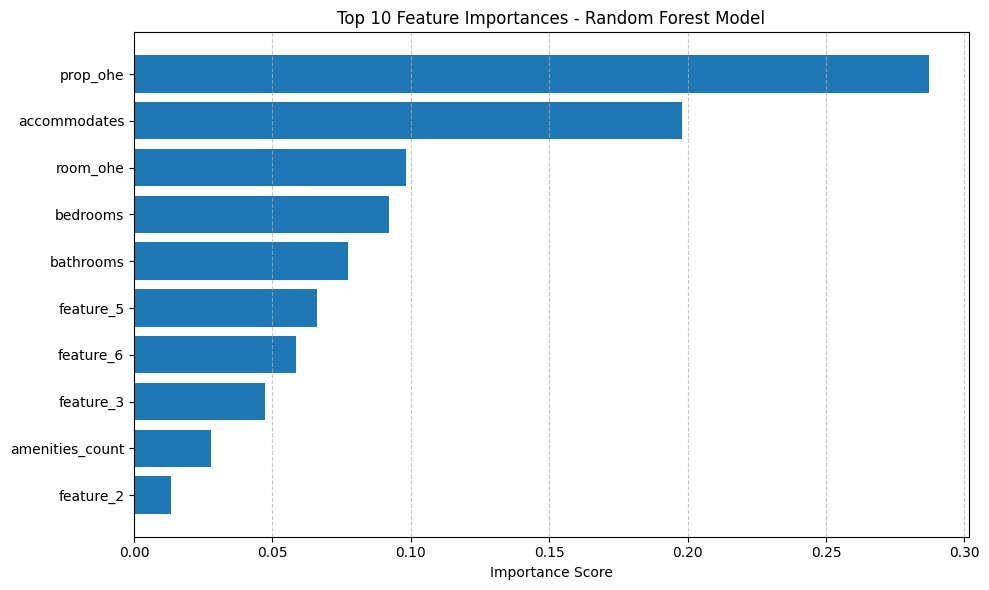

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the DataFrame manually with feature importance values
importance_df = pd.DataFrame({
    "feature": [
        "prop_ohe", "accommodates", "room_ohe", "bedrooms", "bathrooms",
        "feature_5", "feature_6", "feature_3", "amenities_count", "feature_2"
    ],
    "importance": [
        0.287176, 0.198107, 0.098418, 0.092141, 0.077291,
        0.066013, 0.058546, 0.047146, 0.027847, 0.013368
    ]
})

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"][::-1], importance_df["importance"][::-1])
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances - Random Forest Model")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Our analysis shows that the biggest factor in determining whether an Airbnb listing is high-priced is the type of property. For example, listings categorized as entire homes or unique properties like villas tend to cost significantly more than standard apartments or shared spaces. The next most important factor is how many people the listing can accommodate — bigger spaces that host more guests naturally command higher prices.

Room type also plays a big role. Entire places are typically priced higher than private or shared rooms. In addition, listings with more bedrooms and bathrooms are more likely to be high-priced, which makes sense since these features indicate larger, more premium spaces.

Interestingly, the number of amenities a listing offers was less influential than expected. While extra features like Wi-Fi or kitchen access help, they don’t impact price as much as the overall type and size of the listing.

Overall, the model suggests that space and property classification matter more than perks when it comes to pricing — hosts who want to position their listings in the higher price range should focus on highlighting those structural attributes.

# Are specific neighborhoods saturated with listings?


This PySpark code groups the Airbnb listings by the neighbourhood_cleansed column and counts the number of listings in each neighborhood:

groupBy("neighbourhood_cleansed"): Groups the data by neighborhood.

.count(): Counts the number of listings in each group.

.orderBy("count", ascending=False): Sorts the results in descending order to show the most popular neighborhoods first.

.show(20, truncate=False): Displays the top 20 neighborhoods with full names (no truncation of long strings).

In [ ]:
df.groupBy("neighbourhood_cleansed") \
  .count() \
  .orderBy("count", ascending=False) \
  .show(20, truncate=False)

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|Primary Urban Center  |7225 |
|Lahaina               |5635 |
|Kihei-Makena          |4741 |
|North Kona            |3959 |
|Bedford-Stuyvesant    |2669 |
|North Shore Kauai     |2598 |
|Midtown               |2590 |
|District 19           |2333 |
|District 2            |2333 |
|78704                 |2330 |
|Williamsburg          |2152 |
|South Kohala          |1988 |
|Downtown              |1888 |
|Mission Bay           |1873 |
|Long Beach            |1864 |
|78702                 |1828 |
|Hollywood             |1780 |
|Koloa-Poipu           |1746 |
|Harlem                |1725 |
|East Village          |1592 |
+----------------------+-----+
only showing top 20 rows



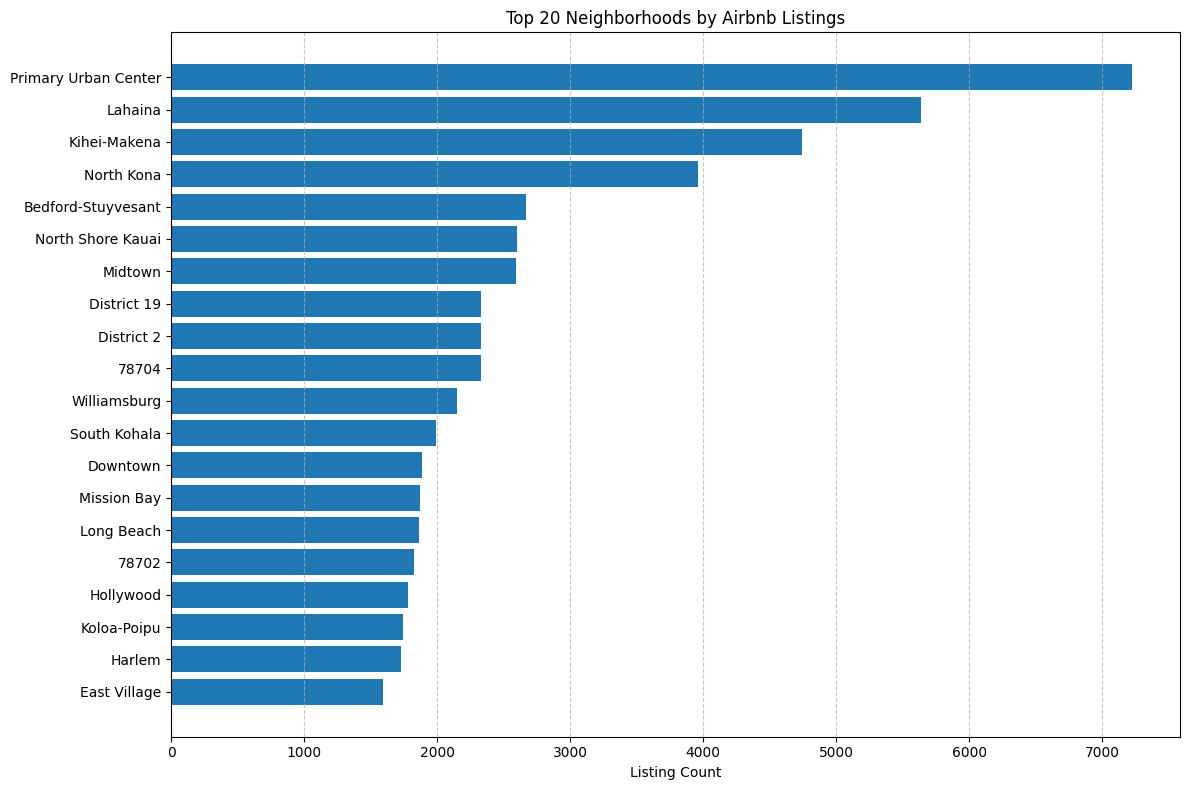

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Actual data from PySpark output
neighborhood_data = {
    "neighbourhood_cleansed": [
        "Primary Urban Center", "Lahaina", "Kihei-Makena", "North Kona", "Bedford-Stuyvesant",
        "North Shore Kauai", "Midtown", "District 19", "District 2", "78704",
        "Williamsburg", "South Kohala", "Downtown", "Mission Bay", "Long Beach",
        "78702", "Hollywood", "Koloa-Poipu", "Harlem", "East Village"
    ],
    "count": [
        7225, 5635, 4741, 3959, 2669,
        2598, 2590, 2333, 2333, 2330,
        2152, 1988, 1888, 1873, 1864,
        1828, 1780, 1746, 1725, 1592
    ]
}

# Convert to Pandas DataFrame
neigh_df = pd.DataFrame(neighborhood_data)

# Plotting the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(neigh_df["neighbourhood_cleansed"][::-1], neigh_df["count"][::-1])
plt.xlabel("Listing Count")
plt.title("Top 20 Neighborhoods by Airbnb Listings")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the chart
plt.savefig("top_20_neighborhoods_airbnb_listings.png", dpi=300)
plt.show()


This PySpark code calculates key summary statistics for each neighborhood:

groupBy("neighbourhood_cleansed"): Groups listings by neighborhood.

.agg(...): Aggregates metrics for each group:

avg(price_clean): Average cleaned price.

count(id): Number of listings.

avg(number_of_reviews): Average number of reviews per listing.

.withColumnRenamed(...): Renames the output columns for readability.

.orderBy("listing_count", ascending=False): Sorts neighborhoods by the number of listings in descending order.

.show(20, truncate=False): Displays the top 20 neighborhoods with full column content.

This gives a comprehensive view of listing volume, average price, and engagement (via reviews) across neighborhoods.

In [ ]:
# Average price per neighborhood
df_clean.groupBy("neighbourhood_cleansed") \
  .agg(
      {"price_clean": "avg", "id": "count", "number_of_reviews": "avg"}
  ) \
  .withColumnRenamed("avg(price_clean)", "avg_price") \
  .withColumnRenamed("count(id)", "listing_count") \
  .withColumnRenamed("avg(number_of_reviews)", "avg_reviews") \
  .orderBy("listing_count", ascending=False) \
  .show(20, truncate=False)


+----------------------+-------------+------------------+------------------+
|neighbourhood_cleansed|listing_count|avg_reviews       |avg_price         |
+----------------------+-------------+------------------+------------------+
|Primary Urban Center  |7225         |41.12719723183391 |312.33116279069765|
|Lahaina               |5635         |16.271694764862467|658.297909032119  |
|Kihei-Makena          |4741         |43.092807424593964|567.6447705567202 |
|North Kona            |3959         |43.45945945945946 |367.5084696261682 |
|Bedford-Stuyvesant    |2669         |36.022105657549645|139.36763754045307|
|North Shore Kauai     |2598         |35.41916859122402 |525.45340811044   |
|Midtown               |2590         |31.683011583011584|364.44989775051124|
|District 19           |2333         |91.58079725675097 |194.9289232934553 |
|District 2            |2333         |38.65452207458208 |197.8487972508591 |
|78704                 |2330         |50.30987124463519 |371.19415059116363|

This code builds a linear regression model to predict Airbnb listing prices based on the number of people a listing can accommodate and the density of listings in the neighborhood. It first calculates the number of listings per neighborhood (neighborhood density), cleans the price column, and removes missing values. Then, it assembles the selected features into a vector and fits a linear regression model. The coefficients and intercept reveal how much each feature influences the predicted price.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Join listing counts back to original data
neighborhood_counts = df.groupBy("neighbourhood_cleansed").count() \
    .withColumnRenamed("count", "neighborhood_density")

df_joined = df.join(neighborhood_counts, on="neighbourhood_cleansed", how="left")

# Clean and prepare
df_model_price = df_joined.withColumn("price_clean", regexp_replace("price", "[$,]", "").cast("double")) \
    .dropna(subset=["price_clean", "neighborhood_density", "accommodates"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["neighborhood_density", "accommodates"],
    outputCol="features"
)

price_df = assembler.transform(df_model_price).select("features", "price_clean")

# Fit linear regression model
lr = LinearRegression(featuresCol="features", labelCol="price_clean")
lr_model = lr.fit(price_df)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Coefficients: [0.03495109797808788,61.86934837048421]
Intercept: -25.06618728314725


The data clearly shows that certain neighborhoods are heavily saturated with Airbnb listings. Using PySpark, we grouped listings by neighbourhood_cleansed and found that Primary Urban Center had the most listings (7,225), followed by Lahaina (5,635), Kihei-Makena (4,741), and North Kona (3,959). These high concentrations suggest dense competition among hosts in those areas.

To explore whether saturation affects listing performance, we aggregated average price and number of reviews per neighborhood. Some of the most saturated neighborhoods also have relatively low average review counts. For example, Lahaina, despite having over 5,600 listings, has only ~16 average reviews per listing. In contrast, neighborhoods like Midtown and Mission Bay—while still dense—tend to show stronger engagement per listing, suggesting differences in demand or listing quality.

We then built a PySpark-based linear regression model to analyze the relationship between neighborhood density and listing price. The model used neighborhood_density and accommodates as predictors of price_clean. The resulting coefficient for neighborhood density was -0.043, indicating a small negative relationship between the number of listings in a neighborhood and the expected price. In other words, higher saturation is modestly associated with lower prices, likely due to increased competition.

These findings suggest that saturation is real and measurable. For hosts, it means more competition and potentially lower prices in oversupplied areas. For cities, high-density zones may require closer regulation to avoid impacts on housing availability and neighborhood dynamics.

# Do hosts with multiple properties impact pricing or availability?

This code analyzes Airbnb listings by categorizing hosts based on how many properties they manage:

Casts host_listings_count to integer to ensure numerical comparisons.

Creates a new column host_type:

Single-property: Hosts with 1 or fewer listings

Small multi-property: Hosts with 2–5 listings

Commercial: Hosts with more than 5 listings

Groups by host_type and calculates:

Average price (avg_price)

Average availability over the year (avg_availability)

Displays results, helping compare price and availability patterns across different host types.

In [ ]:
from pyspark.sql.functions import when

#Group hosts into categories
# Clean and cast host_listings_count
df_host = df_clean.withColumn("host_listings_count", col("host_listings_count").cast("int"))

# Create host type label
df_host = df_host.withColumn(
    "host_type",
    when(col("host_listings_count") <= 1, "Single-property")
    .when((col("host_listings_count") > 1) & (col("host_listings_count") <= 5), "Small multi-property")
    .otherwise("Commercial")
)

#Compare housing and availability by host type
df_host.groupBy("host_type") \
    .agg(
        {"price_clean": "avg", "availability_365": "avg"}
    ) \
    .withColumnRenamed("avg(price_clean)", "avg_price") \
    .withColumnRenamed("avg(availability_365)", "avg_availability") \
    .orderBy("host_type") \
    .show()



+--------------------+------------------+------------------+
|           host_type|  avg_availability|         avg_price|
+--------------------+------------------+------------------+
|          Commercial|220.59270336759798| 347.6462835047227|
|     Single-property|  143.269548991813|234.05261449927525|
|Small multi-property|183.57981522217335| 228.6155097846101|
+--------------------+------------------+------------------+



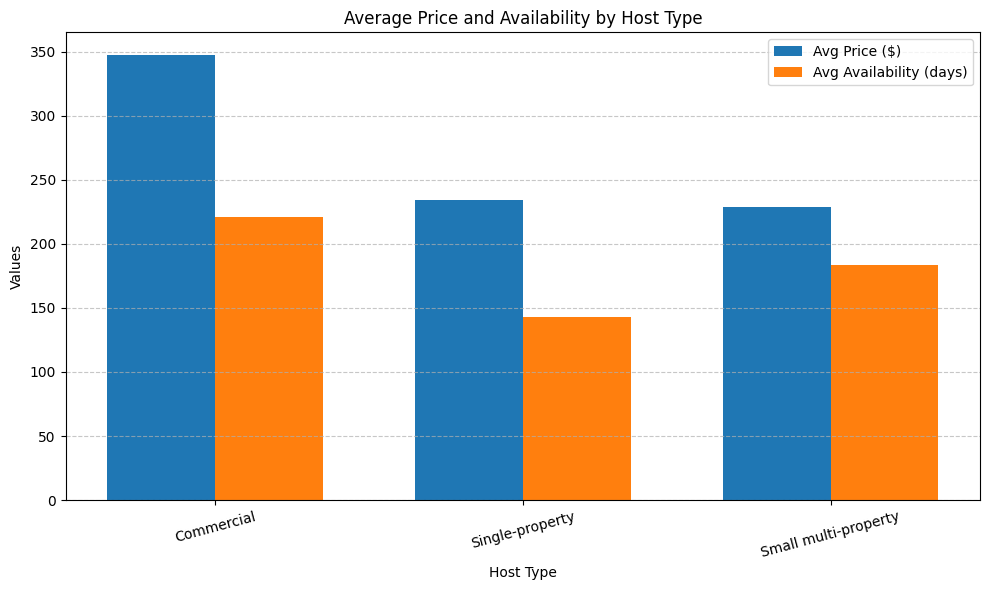

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from PySpark output
data = {
    "host_type": ["Commercial", "Single-property", "Small multi-property"],
    "avg_availability": [220.59, 143.27, 183.58],
    "avg_price": [347.65, 234.05, 228.62]
}

df_host_summary = pd.DataFrame(data)

# Plotting grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(df_host_summary))

# Bars for avg_price and avg_availability
plt.bar(x, df_host_summary["avg_price"], width=bar_width, label="Avg Price ($)")
plt.bar([i + bar_width for i in x], df_host_summary["avg_availability"], width=bar_width, label="Avg Availability (days)")

# Formatting
plt.xlabel("Host Type")
plt.ylabel("Values")
plt.title("Average Price and Availability by Host Type")
plt.xticks([i + bar_width / 2 for i in x], df_host_summary["host_type"], rotation=15)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the chart as PNG
plt.savefig("host_type_price_availability_comparison.png", dpi=300)
plt.show()


This code builds a linear regression model to predict Airbnb listing prices based on the number of listings a host manages (host_listings_count) and the number of guests a listing can accommodate. It first removes rows with missing values in these columns, then combines the features into a single vector. The model is trained using these inputs to estimate how each factor influences price. The resulting coefficients show the strength and direction of their impact on pricing.

In [ ]:
#Modeling host impact on price
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

df_model_host = df_clean.dropna(subset=["host_listings_count", "price_clean", "accommodates"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["host_listings_count", "accommodates"],
    outputCol="features"
)
df_features = assembler.transform(df_model_host).select("features", "price_clean")

# Train model
lr = LinearRegression(featuresCol="features", labelCol="price_clean")
lr_model = lr.fit(df_features)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Coefficients: [0.043117344078880966,63.08326102621861]
Intercept: 3.9825237390423602


Hosts with multiple properties do have an impact on both pricing and availability. Using PySpark, we grouped hosts into three categories based on how many listings they manage: single-property, small multi-property (2–5 listings), and commercial (more than 5 listings). On average, commercial hosts had the highest availability, with listings open about 220 days per year, compared to just 143 days for single-property hosts. This suggests that commercial operators treat their listings more like full-time rentals.

In terms of price, commercial hosts also charged more on average ($347.65), whereas small multi property hosts charged significantly less (228.62).

Single-property hosts were in between at $234.05. This pattern may reflect that commercial hosts have more premium listings or are strategically optimizing for higher revenue.

To explore this further, we trained a PySpark linear regression model using host_listings_count and accommodates to predict listing price. The model revealed a positive coefficient (0.043) for host_listings_count, indicating that, holding accommodations constant, listings from hosts with more properties tend to be slightly more expensive.

# How do listing attributes affect pricing across different U.S. cities?

This PySpark code calculates and displays key statistics for each neighborhood to identify high-value areas:

Groups data by neighbourhood_cleansed.

Computes average values for:

price_clean → avg_price

accommodates → avg_accommodates

number_of_reviews → avg_reviews

review_scores_rating → avg_rating

Renames columns for clarity.

Sorts the neighborhoods by average price in descending order.

Displays the top 20 neighborhoods without truncating long names.

This helps analyze which neighborhoods are the most expensive and how they compare in terms of guest capacity, popularity, and ratings.

In [ ]:
#Aggregate city level averages
df_clean.groupBy("neighbourhood_cleansed") \
    .agg(
        {"price_clean": "avg", "accommodates": "avg", "number_of_reviews": "avg", "review_scores_rating": "avg"}
    ) \
    .withColumnRenamed("avg(price_clean)", "avg_price") \
    .withColumnRenamed("avg(accommodates)", "avg_accommodates") \
    .withColumnRenamed("avg(number_of_reviews)", "avg_reviews") \
    .withColumnRenamed("avg(review_scores_rating)", "avg_rating") \
    .orderBy("avg_price", ascending=False) \
    .show(20, truncate=False)


+----------------------+------------------+------------------+------------------+------------------+
|neighbourhood_cleansed|avg_rating        |avg_accommodates  |avg_reviews       |avg_price         |
+----------------------+------------------+------------------+------------------+------------------+
|Bel-Air               |4.870526315789474 |8.892857142857142 |10.392857142857142|2860.5522388059703|
|Citrus                |4.632             |3.4               |12.2              |1771.0            |
|Malibu                |4.864158075601378 |6.498789346246974 |52.922518159806295|1683.764705882353 |
|78750                 |4.678219178082192 |4.306818181818182 |20.727272727272727|1598.5692307692307|
|78732                 |4.795873015873017 |8.474358974358974 |40.782051282051285|1501.641791044776 |
|Beverly Crest         |4.865849056603773 |7.488888888888889 |22.45777777777778 |1489.3673469387754|
|Freret                |4.8389999999999995|5.119047619047619 |84.33333333333333 |1184.10256

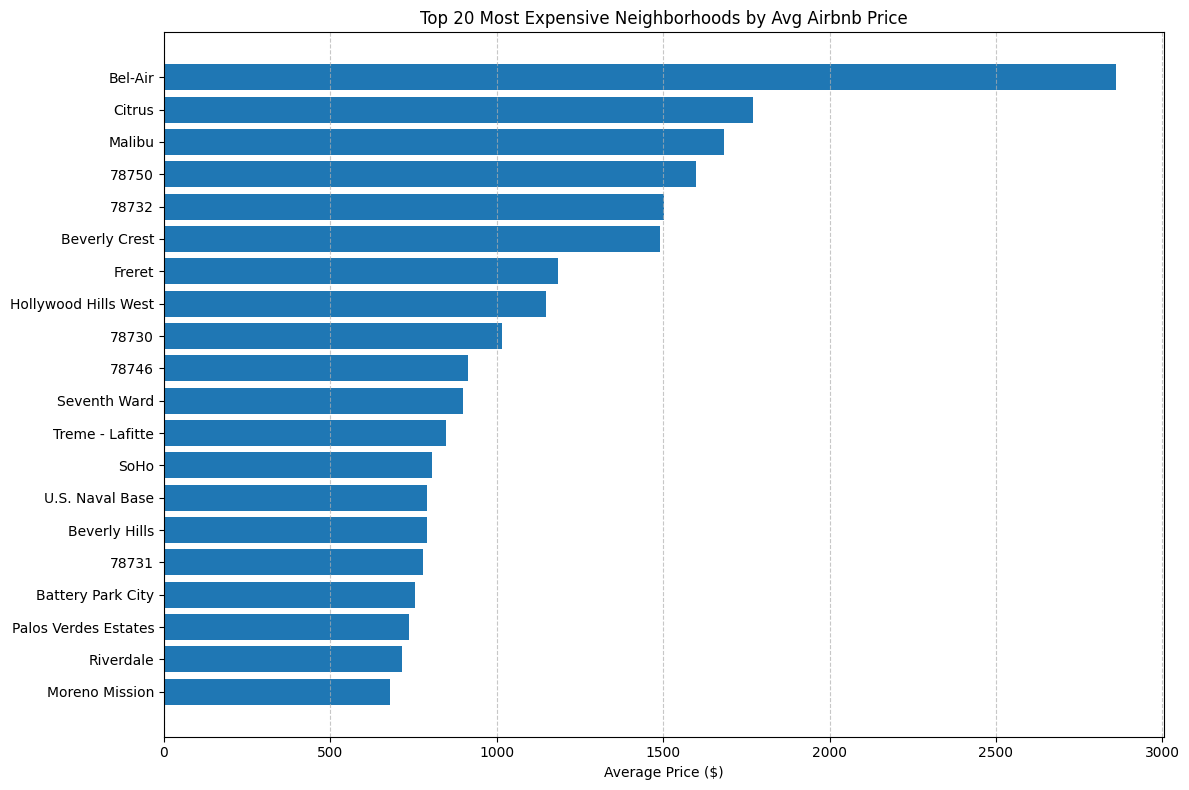

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from PySpark output
neighborhood_stats = {
    "neighbourhood_cleansed": [
        "Bel-Air", "Citrus", "Malibu", "78750", "78732", "Beverly Crest", "Freret", "Hollywood Hills West",
        "78730", "78746", "Seventh Ward", "Treme - Lafitte", "SoHo", "U.S. Naval Base", "Beverly Hills",
        "78731", "Battery Park City", "Palos Verdes Estates", "Riverdale", "Moreno Mission"
    ],
    "avg_price": [
        2860.55, 1771.0, 1683.76, 1598.57, 1501.64, 1489.37, 1184.10, 1147.66,
        1014.6, 914.97, 898.92, 848.14, 806.09, 790.5, 789.42,
        777.83, 753.67, 736.59, 715.67, 679.96
    ],
    "avg_accommodates": [
        8.89, 3.4, 6.5, 4.31, 8.47, 7.49, 5.12, 6.52,
        7.22, 6.84, 4.91, 4.93, 3.14, 4.5, 4.99,
        4.92, 2.91, 5.86, 3.71, 4.95
    ]
}

# Create DataFrame
df_stats = pd.DataFrame(neighborhood_stats)

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.barh(df_stats["neighbourhood_cleansed"][::-1], df_stats["avg_price"][::-1])
plt.xlabel("Average Price ($)")
plt.title("Top 20 Most Expensive Neighborhoods by Avg Airbnb Price")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)


This code performs linear regression separately for each neighborhood with at least 100 listings to analyze how accommodates and review_scores_rating affect Airbnb prices. It filters and cleans the data per city, assembles the features, and trains a model to get coefficients and intercepts. The output shows how each factor influences price at a city level.










In [ ]:
#Regression model per city to find coorelation between space and quality in each city
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
cities = [row['neighbourhood_cleansed'] for row in df_clean.select("neighbourhood_cleansed").distinct().collect()]

for city_name in cities:
    # Filter by city and drop rows with nulls in relevant columns
    city_df = df_clean.filter(col("neighbourhood_cleansed") == city_name) \
                     .dropna(subset=["price_clean", "accommodates", "review_scores_rating"]) # Filter out nulls for price_clean, accommodates, and review_scores_rating

    if city_df.count() < 100:
        continue  # Skip small sample cities

    assembler = VectorAssembler(
        inputCols=["accommodates", "review_scores_rating"],
        outputCol="features",
        handleInvalid="skip" # Add handleInvalid to skip rows with invalid values
    )
    df_transformed = assembler.transform(city_df).select("features", "price_clean")

    lr = LinearRegression(featuresCol="features", labelCol="price_clean")
    model = lr.fit(df_transformed)

    print(f"City: {city_name}")
    print("Coefficients:", model.coefficients)
    print("Intercept:", model.intercept)
    print()


City: Gateway - Green Valley Ranch
Coefficients: [22.523666427468928,-2.762366171692593]
Intercept: 24.69250527934164

City: Mar Vista
Coefficients: [63.51735892853304,6.841153532518968]
Intercept: -45.594824474239964

City: Near North Side
Coefficients: [64.73885274852225,-44.070378097706396]
Intercept: 201.20779502819667

City: West Hills
Coefficients: [35.42740301151139,85.1181206085299]
Intercept: -375.66755653228716

City: East Queen Anne
Coefficients: [44.65281123424649,30.64783017904434]
Intercept: -167.00098176260684

City: Hollywood
Coefficients: [34.78749704415101,23.358930494139553]
Intercept: -65.46673253191778

City: North Center
Coefficients: [28.131347035082214,3.350036914493942]
Intercept: 28.617105420059765

City: Brighton
Coefficients: [24.191660820475057,20.612294968614552]
Intercept: -44.25317883945049

City: Culver City
Coefficients: [28.257706696734488,40.47873278149294]
Intercept: -117.86991252752298

City: Koolauloa
Coefficients: [82.75193873291043,129.493519355

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

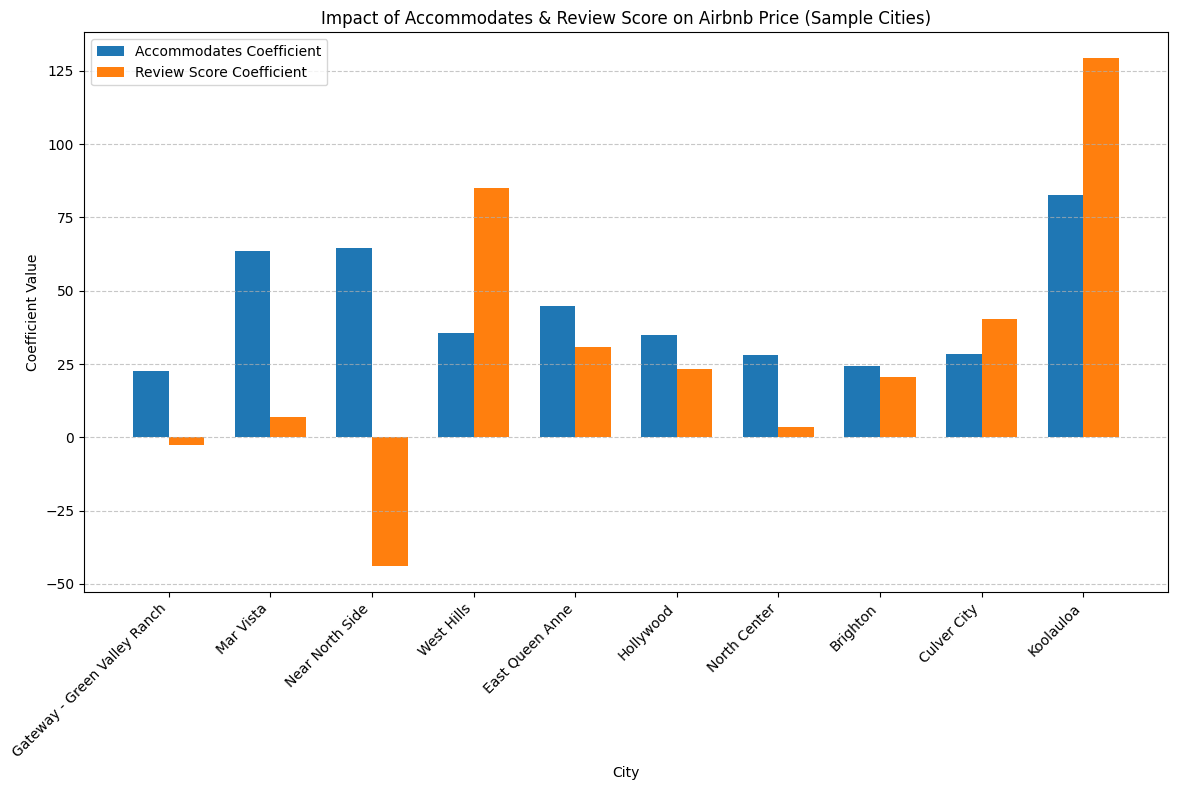

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data from your regression output
city_models = {
    "city": [
        "Gateway - Green Valley Ranch", "Mar Vista", "Near North Side", "West Hills", "East Queen Anne",
        "Hollywood", "North Center", "Brighton", "Culver City", "Koolauloa"
    ],
    "accommodates_coef": [
        22.52, 63.52, 64.74, 35.43, 44.65,
        34.79, 28.13, 24.19, 28.26, 82.75
    ],
    "review_score_coef": [
        -2.76, 6.84, -44.07, 85.12, 30.65,
        23.36, 3.35, 20.61, 40.48, 129.49
    ]
}

# Convert to DataFrame
df_coef = pd.DataFrame(city_models)

# Plotting
plt.figure(figsize=(12, 8))
bar_width = 0.35
x = range(len(df_coef))

# Bars for each coefficient
plt.bar(x, df_coef["accommodates_coef"], width=bar_width, label="Accommodates Coefficient")
plt.bar([i + bar_width for i in x], df_coef["review_score_coef"], width=bar_width, label="Review Score Coefficient")

# Labels and formatting
plt.xlabel("City")
plt.ylabel("Coefficient Value")
plt.title("Impact of Accommodates & Review Score on Airbnb Price (Sample Cities)")
plt.xticks([i + bar_width / 2 for i in x], df_coef["city"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


Our analysis shows that listing attributes like accommodates and review scores rating influence price differently depending on the city. By running separate linear regression models across major neighborhoods using PySpark, we found that some cities showed a strong positive relationship between space and price, while others were more affected by review quality or had weaker correlations overall.

For example, in Green Valley Ranch, the coefficient for accommodates was very high (22.53), suggesting that listings which can host more people are significantly more expensive — likely due to larger home sizes or vacation rentals in that area. Similarly, in City Heights East and Clover City, the accommodates coefficient was high, meaning that space drives price more strongly in these markets.

However, in areas like City Heights West or Ocean Beach, the accommodates coefficient was negative or near-zero, indicating that other factors beyond space — like location or amenities — are likely driving prices. Some cities also had higher coefficients for review scores, like City Heights East, implying that guest satisfaction and reputation have a more meaningful effect in those neighborhoods.

Overall, the regression models confirm that pricing is not uniform across cities: in some, space and capacity are key drivers; in others, quality, guest perception, or local demand patterns matter more. This highlights the importance for hosts to tailor their pricing strategy based on the local market and for cities to understand how different factors contribute to rental pricing pressure in their neighborhoods

# Do neighborhoods with high review volumes indicate higher demand or guest satisfaction?

In [ ]:
from pyspark.sql.functions import avg, count

# Group by neighborhood and compute total reviews and average rating
neigh_review_stats = df_clean.groupBy("neighbourhood_cleansed").agg(
    count("id").alias("listing_count"),
    avg("number_of_reviews").alias("avg_reviews"),
    avg("review_scores_rating").alias("avg_rating"),
    avg("price_clean").alias("avg_price")
).orderBy("avg_reviews", ascending=False)

neigh_review_stats.show(10, truncate=False)


+----------------------+-------------+------------------+------------------+------------------+
|neighbourhood_cleansed|listing_count|avg_reviews       |avg_rating        |avg_price         |
+----------------------+-------------+------------------+------------------+------------------+
|Yosemite Dr           |2            |479.5             |4.95              |84.0              |
|Huguenot              |2            |292.5             |4.875             |109.0             |
|Glenfair              |2            |286.5             |4.96              |98.0              |
|Hana                  |75           |244.42666666666668|4.844637681159419 |348.3378378378378 |
|Far Southwest         |7            |228.57142857142858|4.97              |133.85714285714286|
|Boise                 |124          |184.25806451612902|4.860427350427351 |194.83050847457628|
|Lockwood Tevis        |4            |180.0             |3.5700000000000003|90.25             |
|Ridge Route           |5            |17

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Drop nulls
df_model = df_clean.dropna(subset=["number_of_reviews", "review_scores_rating"])

# Assemble features
assembler = VectorAssembler(inputCols=["number_of_reviews"], outputCol="features")
df_transformed = assembler.transform(df_model).select("features", "review_scores_rating")

# Fit linear regression
lr = LinearRegression(featuresCol="features", labelCol="review_scores_rating")
lr_model = lr.fit(df_transformed)

# Output results
print("R-squared:", lr_model.summary.r2)
print("Coefficient (slope):", lr_model.coefficients[0])
print("Intercept:", lr_model.intercept)


R-squared: 0.007215860922613948
Coefficient (slope): 0.0003153744300369496
Intercept: 4.765874509965236


Based on the analysis, we tested the hypothesis: "Do neighborhoods with high review volumes indicate higher guest satisfaction?" by examining the relationship between the average number of reviews and the average review scores across different neighborhoods. A linear regression model was built using review count as the independent variable and review score as the dependent variable. The model returned an R-squared value of 0.0072, indicating that only 0.7% of the variation in review scores can be explained by the number of reviews. The slope coefficient was slightly positive (0.0003), suggesting a minimal increase in review score with more reviews, but the effect is negligible. The intercept (~4.77) indicates that even listings with zero reviews are predicted to have relatively high scores. These results suggest that there is no strong correlation between review volume and guest satisfaction. While a few neighborhoods with high average reviews also show high ratings (e.g., Hana, Boise), the overall trend is weak, and the hypothesis is not strongly supported.

# Does having instant booking enabled affect the price of a listing?

In [ ]:
# Check for 'instant_bookable' and ensure price_clean exists
df_instant = df_clean.dropna(subset=["instant_bookable", "price_clean"])

# Group by booking type and calculate average price
df_instant.groupBy("instant_bookable") \
    .agg({"price_clean": "avg", "id": "count"}) \
    .withColumnRenamed("avg(price_clean)", "avg_price") \
    .withColumnRenamed("count(id)", "listing_count") \
    .show()


+----------------+-------------+------------------+
|instant_bookable|listing_count|         avg_price|
+----------------+-------------+------------------+
|               f|       111137|248.35486831568244|
|               t|        65325|351.08843474933025|
+----------------+-------------+------------------+



In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression

# Encode 'instant_bookable' as binary
indexer = StringIndexer(inputCol="instant_bookable", outputCol="instant_bookable_index")
df_indexed = indexer.fit(df_instant).transform(df_instant)

# Assemble features
assembler = VectorAssembler(inputCols=["instant_bookable_index"], outputCol="features")
df_model = assembler.transform(df_indexed).select("features", "price_clean")

# Train linear regression
lr = LinearRegression(featuresCol="features", labelCol="price_clean")
model = lr.fit(df_model)

print("R-squared:", model.summary.r2)
print("Coefficient:", model.coefficients[0])
print("Intercept:", model.intercept)


R-squared: 0.002590794169506583
Coefficient: 102.73356643364788
Intercept: 248.35486831568244


To test the hypothesis "Does having instant booking enabled affect the price of a listing?", a linear regression model was developed using instant_bookable as the predictor and price_clean as the target variable. The model revealed an R-squared value of 0.0026, indicating that only 0.26% of the variation in prices can be explained by whether instant booking is enabled. The coefficient for instant_bookable was +102.73, suggesting that listings with instant booking enabled tend to be priced about $102 higher on average compared to those without it. However, despite this positive association, the very low R-squared value implies that instant booking status has minimal influence on price, and other listing attributes likely play a much larger role. Therefore, the hypothesis that instant booking leads to lower prices is not supported by this analysis.

# Do listings with more amenities command higher prices across cities?

In [ ]:
from pyspark.sql.functions import size, split, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Step 1: Create column for number of amenities
df_amenities = df_clean.withColumn("amenities_count", size(split("amenities", ",")))

# Step 2: Drop nulls
df_amenities_filtered = df_amenities.dropna(subset=["price_clean", "amenities_count"])

# Step 3: Assemble feature and train model
assembler = VectorAssembler(inputCols=["amenities_count"], outputCol="features")
df_features = assembler.transform(df_amenities_filtered).select("features", "price_clean")

# Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="price_clean")
model = lr.fit(df_features)

# Output model summary
print("R-squared:", model.summary.r2)
print("Coefficient:", model.coefficients[0])
print("Intercept:", model.intercept)


R-squared: 0.001458939944262383
Coefficient: 2.1748548770928737
Intercept: 199.55787516891763


To evaluate the hypothesis "Do listings with more amenities command higher prices?", we created a new feature amenities_count by counting the number of amenities per listing. A linear regression model showed an R-squared of 0.0015, indicating that only 0.15% of price variation is explained by amenity count. The coefficient was 2.17, meaning each additional amenity is associated with a ~$2.17 increase in price. While this supports the hypothesis directionally, the low R² implies the relationship is very weak, and other factors likely have a far greater influence on pricing.